<a href="https://colab.research.google.com/github/mdaugherity/Numerical2024/blob/main/ode/Week_10_BVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dr. Daugherity, PHYS 351, Fall 2024**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import solve_bvp

# EXAMPLE 1 - IVP vs BVP: 1D projectile motion

y(t) = height of ball at time t

y'' = -g

## IVP Problem
y(0) = 0, y'(0) = 15

The solver successfully reached the end of the integration interval.


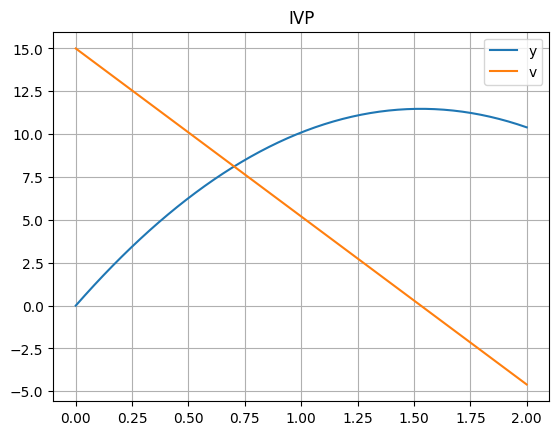

In [ ]:
def yprime(t,yvec):
  y = yvec[0]
  v = yvec[1]
  return [v, -9.8]

y0 = [0, 15]  # Initial Values
TMAX = 2


ivp = solve_ivp(yprime, [0,TMAX], y0, dense_output=1)
print(ivp.message)

t = np.linspace(0,TMAX, 50)
yint = ivp.sol(t)
y = yint[0]
v = yint[1]

plt.plot(t,y,label='y')
plt.plot(t,v,label='v')
plt.legend()
plt.grid()
plt.title('IVP')
plt.show()

## SHOOTING METHOD!

Suppose instead of **initial values** $y(0), y'(0)$ we were given **boundary values** at different times.

Calling *solve_ivp* requires the initial values, so we have to use root finding to "shoot for" the initial values that give us the boundary conditions we want!

## CASE 1:  y(0)=0, y(2)=10
What initial speed does the ball have so that it is 10 m above the ground 2 seconds later?

In [ ]:
# define a function to match BC
# want y(2)=10
def bc(v0):
  y0 = [0, v0]  # Initial Values
  ivp = solve_ivp(yprime, [0,TMAX], y0)
  y = ivp.y[0]
  yf = y[-1]
  v = ivp.y[1]
  vf = v[-1]
  return yf - 10

In [ ]:
# Play with function to estimate root
bc(15)

0.40000000000001457

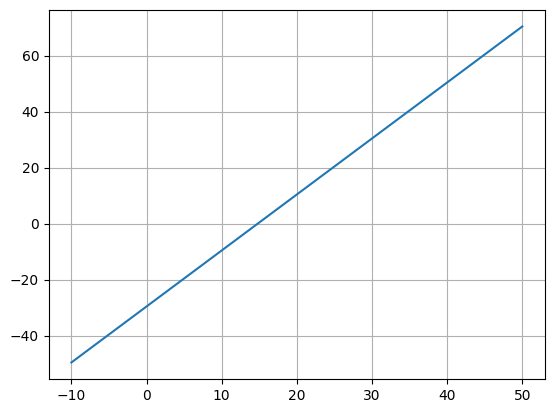

In [ ]:
v0 = np.linspace(-10,50)
res = np.zeros_like(v0)
for i in range(len(v0)):
  res[i] = bc(v0[i])

plt.plot(v0, res)
plt.grid()
plt.show()

In [ ]:
from scipy.optimize import root_scalar

In [ ]:
# root is a little less than 15.  Use initial guesses x0,x1
sol = root_scalar(bc, x0=15, x1 = 14.9)
print(sol)

      converged: True
           flag: converged
 function_calls: 3
     iterations: 2
           root: 14.799999999999995
         method: secant


The solver successfully reached the end of the integration interval.


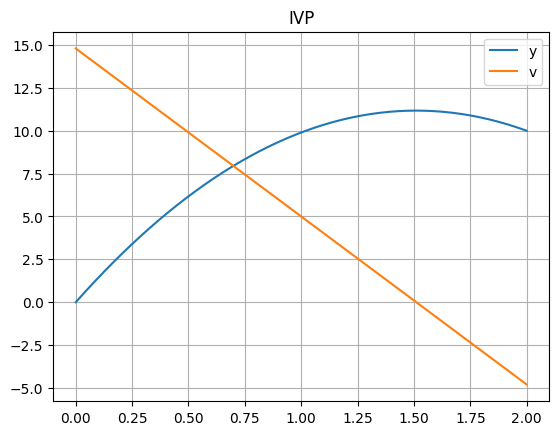

In [ ]:
# Now that we know the right value for vp0, run solve_ivp one final time
yp0 = sol.root
y0 = [0, yp0]  # Initial Values
t = np.linspace(0,TMAX, 50)
ivp = solve_ivp(yprime, [0,TMAX], y0, t_eval = t)
print(ivp.message)

y = ivp.y[0]
v = ivp.y[1]

plt.plot(t,y,label='y')
plt.plot(t,v,label='v')
plt.legend()
plt.grid()
plt.title('IVP')
plt.show()

Yes indeed, we ended up at y(2)=10

## CASE 2: y(0)=0, y'(2)=5

We'll do the problem in a single cell this time

      converged: True
           flag: converged
 function_calls: 4
     iterations: 3
           root: 24.6
         method: brentq
The solver successfully reached the end of the integration interval.


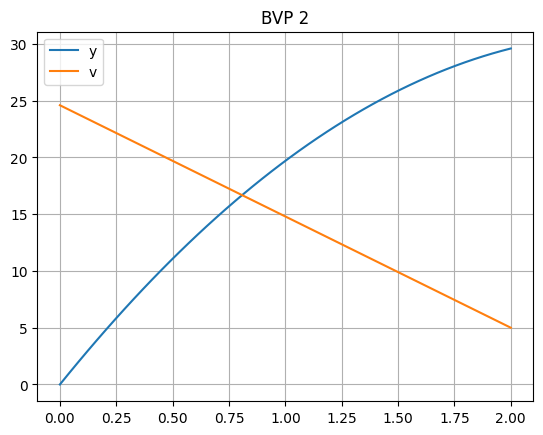

In [ ]:
def bc(yp0):
  y0 = [0, yp0]  # Initial Values
  ivp = solve_ivp(yprime, [0,TMAX], y0)
  return ivp.y[1][-1] - 5

sol = root_scalar(bc, bracket=[0,100])  # using a huge bracket
print(sol)
yp0 = sol.root

y0 = [0, yp0]  # Initial Values
TMAX = 2
t = np.linspace(0,TMAX, 50)
ivp = solve_ivp(yprime, [0,TMAX], y0, t_eval = t)
print(ivp.message)

y = ivp.y[0]
v = ivp.y[1]

plt.plot(t,y,label='y')
plt.plot(t,v,label='v')
plt.grid()
plt.legend()
plt.title('BVP 2')
plt.show()

# EXAMPLE 8.2
y'' = 4t - 4y
what y'(0) gives y'(2)=0

      converged: True
           flag: 'converged'
 function_calls: 6
     iterations: 5
           root: 2.5312521828760755
The solver successfully reached the end of the integration interval.


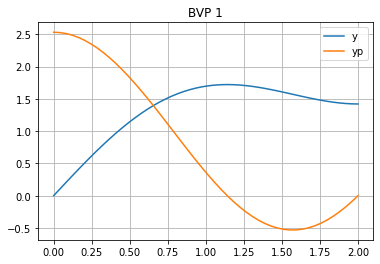

In [ ]:
TMAX = 2

def f(t,y):
  y0 = y[0]
  y1 = y[1]
  return [y1, 4*t - 4*y0]

def bc(yp0):
  y0 = [0, yp0]  # Initial Values
  ivp = solve_ivp(f, [0,TMAX], y0)
  return ivp.y[1][-1] - 0

sol = root_scalar(bc, bracket=[0,3])
print(sol)
yp0 = sol.root

y0 = [0, yp0]  # Initial Values
TMAX = 2
t = np.linspace(0,TMAX, 50)
ivp = solve_ivp(f, [0,TMAX], y0, t_eval = t)
print(ivp.message)

y = ivp.y[0]
v = ivp.y[1]

plt.plot(t,y,label='y')
plt.plot(t,v, label='yp')
plt.legend()
plt.grid()
plt.title('BVP 1')
plt.show()

In [ ]:
bc(3)

-0.3062196542705997